# Credit Default Swap (CDS) Pricing — Annotated Notebook

This notebook is part of an assignment in the **Credit Risk Modeling course** of the MFE program at Chulalongkorn University.  
It explains each step in detail and provides runnable code to reproduce the figures and results.

---
## Roadmap
**1. Nelson–Siegel yield curve & discount factors**
**2. Standard CDS schedule construction & day-count fractions**  
**3. Survival curve model (piecewise-constant hazard), calibration logic**  
**4. Newton/Root-finding for segment hazards**  
**5. Plotting survival and intermediate objects**  
**6. Non-standard CDS valuation (mark-to-market/legs/accrued)**  

## Case Description — CDS Valuation Assignment

### Standard CDS (Trade Date: 17 Dec 2014)
- **Trade Date:** 17 December 2014  
- **Effective Date (T+1):** 18 December 2014  
- **Maturity Dates:** Standard IMM-style — 20 Mar, 20 Jun, 20 Sep, 20 Dec  
- **Payment Frequency:** Quarterly (4× per year)  
- **Business Day Convention:** Modified Following (roll weekends to Monday; no holidays assumed)  
- **Expected Recovery Rate:** 40%  

**Market Spreads (as of 17 Dec 2014):**

| Tenor | Maturity Date | Spread (bp) |
|-------|---------------|-------------|
| 6M    | 20 Jun 2015   | 2.58        |
| 1Y    | 20 Dec 2015   | 3.69        |
| 2Y    | 20 Dec 2016   | 6.62        |
| 3Y    | 20 Dec 2017   | 10.62       |
| 4Y    | 20 Dec 2018   | 14.62       |
| 5Y    | 20 Dec 2019   | 20.47       |
| 7Y    | 20 Dec 2021   | 30.00       |
| 10Y   | 20 Dec 2024   | 50.63       |
| 20Y   | 20 Dec 2034   | 69.66       |
| 30Y   | 20 Dec 2044   | 75.48       |

---

### Non-Standard CDS
- **Issuer:** Same as standard CDS (Boeing Company)  
- **Valuation Date:** 17 December 2014  
- **Effective Date:** 15 May 2012  
- **Maturity Date:** 15 May 2037  
- **Face Value:** \$100 million (long protection)  
- **Contractual Spread:** 80 bp  
- **Premium Dates:** 15 Feb, 15 May, 15 Aug, 15 Nov (quarterly, non-standard)  
- **Business Day Convention:** Modified Following  
- **Day Count Convention:** Actual/360  
- **Expected Recovery Rate:** 55%  

---

### Parameters
- **Interest Rate Curve:** Nelson–Siegel (continuously compounded, annualized)  
  - β₀ = 0.0408  
  - β₁ = −0.0396  
  - β₂ = −0.0511  
  - τ = 1.614  
- **Numerical Settings (for calibration / MTM):**  
  - m = 12 intervals per year (monthly grid)  
  - Newton–Raphson tolerance: ε = 10⁻⁶  
  - Initial guess: x₀ = 0.01  


## 1) Nelson–Siegel term structure (r̂(s)) and discount factors Z(0,s)
We fit a smooth curve to continuously compounded **Libor** rates using the modified Nelson–Siegel specification:
$$ \hat r(s) = \beta_0 + \beta_1\,\frac{\tau}{s}(1-e^{-s/\tau}) + \beta_2\left(\frac{\tau}{s}(1-e^{-s/\tau}) - e^{-s/\tau}\right) $$
Discount factors are then:  
$$ Z(0,s) = e^{-\hat r(s)\, s} $$
These definitions align with the assignment handout’s Section 2.1 and will be used across all legs of valuation.


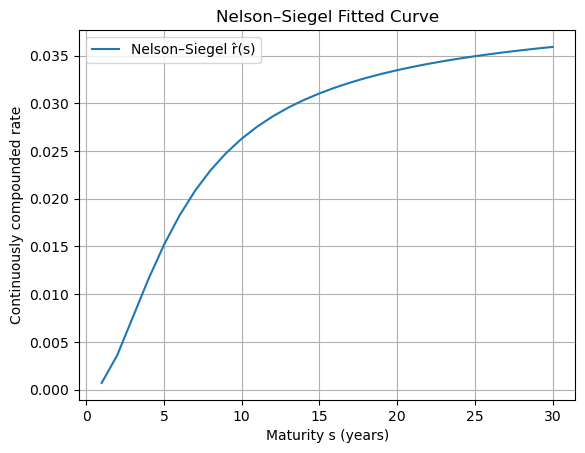

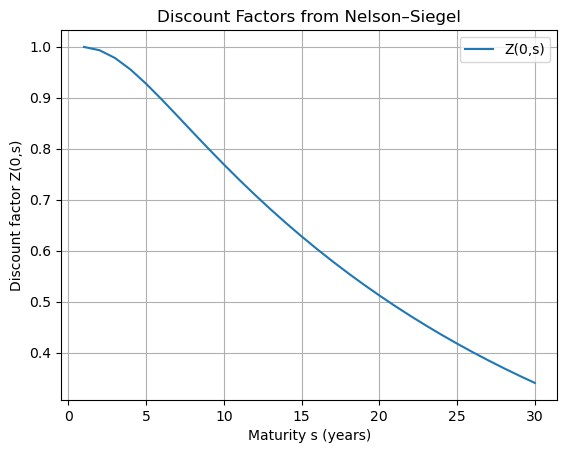

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
import math
from datetime import datetime, timedelta

# --- Nelson-Siegel parameters (from assignment) ---
beta0 = 0.0408
beta1 = -0.0396
beta2 = -0.0511
tau   = 1.614

# --- Maturities (years) for plotting and tables ---
time_years = np.linspace(1, 30, 30)  # 1..30 years

def nelson_siegel_rate(s):
    """0-safe modified Nelson–Siegel. Returns scalar for scalar input, array for array input."""
    s_arr = np.asarray(s, dtype=float)
    out = np.empty_like(s_arr)

    # mask for s==0
    m0 = (s_arr == 0.0)
    # limit at 0: r(0+) = beta0 + beta1
    out[m0] = beta0 + beta1

    # s>0 branch
    mp = ~m0
    sp = s_arr[mp]
    if sp.size:
        term = (tau / sp) * (1.0 - np.exp(-sp / tau))
        out[mp] = beta0 + beta1 * term + beta2 * (term - np.exp(-sp / tau))

    # return scalar if input was scalar
    return float(out.item()) if np.isscalar(s) else out


def discount_factor(s, r=None):
    """0-safe discount factor. Z(0,0)=1 by definition."""
    s_arr = np.asarray(s, dtype=float)
    if r is None:
        r_arr = nelson_siegel_rate(s_arr)
    else:
        r_arr = np.asarray(r, dtype=float)

    out = np.exp(-r_arr * s_arr)
    # force Z(0)=1 exactly (avoids any tiny numeric drift)
    out = np.where(s_arr == 0.0, 1.0, out)

    return float(out.item()) if np.isscalar(s) else out


rates = nelson_siegel_rate(time_years)
dfs   = discount_factor(time_years, rates)

fig1 = plt.figure()
plt.plot(time_years, rates, label="Nelson–Siegel r̂(s)")
plt.xlabel("Maturity s (years)"); plt.ylabel("Continuously compounded rate")
plt.title("Nelson–Siegel Fitted Curve")
plt.grid(True); plt.legend(); plt.show()

fig2 = plt.figure()
plt.plot(time_years, dfs, label="Z(0,s)")
plt.xlabel("Maturity s (years)"); plt.ylabel("Discount factor Z(0,s)")
plt.title("Discount Factors from Nelson–Siegel")
plt.grid(True); plt.legend(); plt.show()


## 2) Standard CDS payment schedule & day counts
Standard CDS premium dates are the IMM-style quarterlies: **Mar 20, Jun 20, Sep 20, Dec 20**. We generate all such dates from **2014 to 2044**, then roll any weekend to Monday ("modified following" without holidays). We compute Actual/360 day-count deltas between consecutive premium dates and accumulate to build time grids used by the approximation formulae.


In [26]:

from datetime import datetime, timedelta

# Quarter dates (day, month)
months_days = [(3, 20), (6, 20), (9, 20), (12, 20)]
start_year, end_year = 2014, 2044

# Build raw schedule (strings), then apply weekend roll
eff_date_str = "18-12-2014"  # T+1 from trade date (17 Dec 2014)
eff_date = datetime.strptime(eff_date_str, "%d-%m-%Y")

def roll_weekend_to_monday(dt):
    wd = dt.weekday()
    if wd == 5:   # Sat
        return dt + timedelta(days=2)
    if wd == 6:   # Sun
        return dt + timedelta(days=1)
    return dt

# Generate and roll
schedule = []
for y in range(start_year, end_year + 1):
    for m, d in months_days:
        schedule.append(f"{d:02d}-{m:02d}-{y}")

# Remove the first 3 elements as in original code (to start after the effective date window)
schedule = schedule[3:]

# Build arrays: convention-adjusted dates (strings), deltas (year fractions), and cumulative times (years)
conv_dates = []
deltas = []
time_grid = [1e-7]  # tiny positive start to avoid divide-by-zero

# Anchor the first element to the effective date
conv_dates.append(eff_date.strftime("%d-%m-%Y"))

for date_str in schedule:
    dt = datetime.strptime(date_str, "%d-%m-%Y")
    dt = roll_weekend_to_monday(dt)
    prev = datetime.strptime(conv_dates[-1], "%d-%m-%Y")
    delta = (dt - prev).days / 360.0  # Actual/360
    conv_dates.append(dt.strftime("%d-%m-%Y"))
    deltas.append(delta)
    time_grid.append(time_grid[-1] + delta)

# remove the second element (to mirror original sequence)
time_grid.pop(1)

conv_dates[:6], deltas[:5], time_grid[:6]


(['18-12-2014',
  '22-12-2014',
  '20-03-2015',
  '22-06-2015',
  '21-09-2015',
  '21-12-2015'],
 [0.011111111111111112,
  0.24444444444444444,
  0.2611111111111111,
  0.25277777777777777,
  0.25277777777777777],
 [1e-07,
  0.25555565555555554,
  0.5166667666666667,
  0.7694445444444444,
  1.0222223222222222,
  1.2750001])

## 3) Market CDS tenors and sub-intervals
We map the 10 standard maturities in the table to **time in years** from the effective date. For each tenor, we also set **K = ⌈m·T⌉** with monthly sub-intervals (m=12) to approximate integrals in the legs, as in the handout.


In [27]:

# From the assignment's Table 1 (before weekend adjustment):
spreads_bp = [2.58, 3.69, 6.62, 10.62, 14.62, 20.47, 30.00, 50.63, 69.66, 75.48]
spreads = np.array(spreads_bp) * 1e-4  # convert bp to decimal

trade_date = datetime.strptime("17-12-2014", "%d-%m-%Y")

# The exact dates from the table (strings), then we roll for weekend adjustment
tenors_str = ["20 Jun 2015", "20 Dec 2015", "20 Dec 2016", "20 Dec 2017", "20 Dec 2018",
              "20 Dec 2019", "20 Dec 2021", "20 Dec 2024", "20 Dec 2034", "20 Dec 2044"]

def to_years_from_eff(datestr, anchor=eff_date):
    dt = datetime.strptime(datestr, "%d %b %Y")
    dt = roll_weekend_to_monday(dt)
    return (dt - anchor).days / 360.0

maturities_years = [to_years_from_eff(s) for s in tenors_str]

# Number of sub-intervals per year (monthly) and K for each tenor
m = 12
K_list = [math.ceil(m * T) for T in maturities_years]

maturities_years, K_list


([0.5166666666666667,
  1.0222222222222221,
  2.036111111111111,
  3.05,
  4.063888888888889,
  5.0777777777777775,
  7.108333333333333,
  10.152777777777779,
  20.29722222222222,
  30.444444444444443],
 [7, 13, 25, 37, 49, 61, 86, 122, 244, 366])

## 4) Survival curve with piecewise-constant hazard
We model the survival probability as $$ Q(t) = -\exp\{\int_0^t h(u)\,du\} $$ with **piecewise-constant** hazard, $$ h(t) = h_k \quad for \quad t\in (T_{k-1},T_k] $$,\
the closed form on each segment is:
$$ Q(t) = \exp\big(-\sum_{i=1}^{k-1} (T_i - T_{i-1})h_i - (t - T_{k-1})h_k\big),\quad t\in (T_{k-1},T_k]. $$
We will calibrate $h_k$ sequentially so that each observed market CDS spread is matched approximately (numerical root-finding).


In [28]:
T_knots = list(maturities_years)           # [T1, ..., TM]
h = np.zeros(len(T_knots), dtype=float)    # to be calibrated

# Build quarterly premium times (years) from the effective date
prem_times_years = []
for ds in conv_dates[1:]:  # skip the anchor (effective date itself)
    prem_times_years.append((datetime.strptime(ds, "%d-%m-%Y") - eff_date).days / 360.0)
prem_times_years = np.array(sorted(prem_times_years), dtype=float)
def Z_func(t):
    return discount_factor(t, nelson_siegel_rate(t))

def objective_for_segment(i, h_i):
    """(1-R)*ProtLeg(T_i) - S_i*RPV01(T_i); returns a Python float."""
    h_tmp = h.copy()
    h_tmp[i] = float(h_i)

    T_i = float(T_knots[i])
    K_i = math.ceil(12 * T_i)  # monthly grid count

    # Quarterly premium times up to T_i (inclusive with small epsilon)
    prem = prem_times_years[prem_times_years <= T_i + 1e-12]
    if prem.size == 0:
        raise RuntimeError(
            f"No premium dates found up to T_{i+1}={T_i:.6f}y — check schedule construction."
        )

    prot = protection_leg_approx(T_i, K_i, piecewise_Q, Z_func, T_knots[:i+1], h_tmp[:i+1])
    rpv  = rpv01_approx(prem, piecewise_Q, Z_func, T_knots[:i+1], h_tmp[:i+1])

    # spreads[i] must be decimal (e.g., 75.48 bp -> 0.007548)
    return float((1.0 - R) * prot - float(spreads[i]) * rpv)

def find_bracket(i, lo=1e-8, hi=200.0, n=400):
    """Log-space scan for a sign-change bracket for segment i."""
    xs = np.geomspace(lo, hi, num=n)
    f_prev = objective_for_segment(i, xs[0])
    x_prev = xs[0]
    for x in xs[1:]:
        fx = objective_for_segment(i, x)
        if np.sign(f_prev) == 0:
            return (x_prev * 0.9, x_prev * 1.1)  # tiny bracket around a near-zero
        if np.sign(f_prev) != np.sign(fx):
            return (x_prev, x)
        x_prev, f_prev = x, fx
    return None


## 5) Premium/Protection legs (approximation)
Following the handout approximations:

- Protection leg numerator uses monthly sub-intervals on $[0,T]:$ 
 $$ \tfrac{1}{2}\sum_k \big(Z(s_{k-1}) + Z(s_k)\big)\big(Q(s_{k-1}) - Q(s_k)\big) $$
- Premium leg denominator (RPV01) uses quarterly premium dates with midpoint approximation inside each period.


In [29]:

def protection_leg_approx(T, K, Q_func, Z_func, T_knots, h):
    # Monthly grid on [0,T]
    s = np.linspace(0.0, T, K+1)
    Zs = Z_func(s)
    Qs = Q_func(s, T_knots, h)
    return 0.5 * np.sum((Zs[:-1] + Zs[1:]) * (Qs[:-1] - Qs[1:]))

def rpv01_approx(premium_times, Q_func, Z_func, T_knots, h):
    # Sum over premium dates t_n, using midpoint approximation for the integral term
    # Here we implement the simplified assignment form:
    # 0.5 * sum Δ(t_{n-1}, t_n) Z(0, t_n) [Q(t_{n-1}) + Q(t_n)]
    acc = 0.0
    t_prev = 0.0
    for t_n in premium_times:
        delta = t_n - t_prev
        Zt = Z_func(t_n)
        Qtm1 = Q_func(t_prev, T_knots, h)
        Qt   = Q_func(t_n,    T_knots, h)
        acc += 0.5 * delta * Zt * (Qtm1 + Qt)
        t_prev = t_n
    return acc


## 6) Calibrate $ h_k $ sequentially to match each on-market spread
We solve $ V_i(h_i) = 0 $ for each tenor $ T_i $ using a 1-D root finder, where 
$$ V_i(h_i) = (1-R)\,\text{Protection Leg}(T_i) - S_i\,\text{RPV01}(T_i) $$
We use the **quarterly** premium schedule up to $ T_i $ (from Section 2), the **monthly** protection grid, and the Nelson–Siegel discount factors.


In [30]:
# ---- Calibrate each hazard segment sequentially ----
for i in range(len(T_knots)):
    f0 = float(objective_for_segment(i, 1e-10))
    fH = float(objective_for_segment(i, 50.0))

    if np.sign(f0) == np.sign(fH):
        bracket = find_bracket(i, lo=1e-10, hi=200.0, n=400)
    else:
        bracket = (1e-10, 50.0)

    solved = False
    if bracket is not None:
        sol = root_scalar(lambda x: objective_for_segment(i, x),
                          bracket=bracket, method="brentq",
                          xtol=1e-12, rtol=1e-10, maxiter=200)
        if sol.converged and sol.root > 0:
            h[i] = float(sol.root)
            solved = True

    if not solved:
        # Secant fallback (no bracket needed)
        x0, x1 = 1e-6, 0.05
        sol2 = root_scalar(lambda x: objective_for_segment(i, x),
                           x0=x0, x1=x1, method="secant",
                           xtol=1e-12, rtol=1e-10, maxiter=200)
        if sol2.converged and sol2.root > 0:
            h[i] = float(sol2.root)
            solved = True

    if not solved:
        # Scalar-safe diagnostics
        raise RuntimeError(
            f"Root find failed for segment {i+1}. "
            f"Diagnostics: f(1e-10)={f0:.6e}, f(50)={fH:.6e}. "
            f"Check premium dates up to T_{i+1}, spreads units (bp→decimal), "
            f"recovery R, and Nelson–Siegel parameters."
        )

h  # calibrated hazards

array([0.00042999, 0.00080406, 0.0015968 , 0.00312617, 0.00450388,
       0.00754143, 0.00941043, 0.01830662, 0.0168758 , 0.01717536])

## 7) Forward default rates (h) and survival curve Q(t)
We visualize the calibrated **piecewise hazard** and the resulting **survival probability** over 0–30 years.


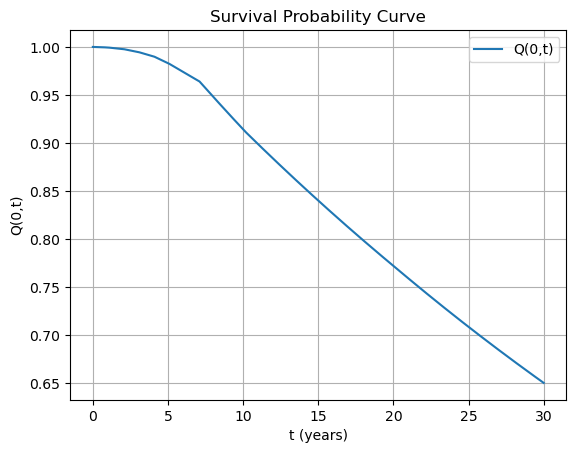

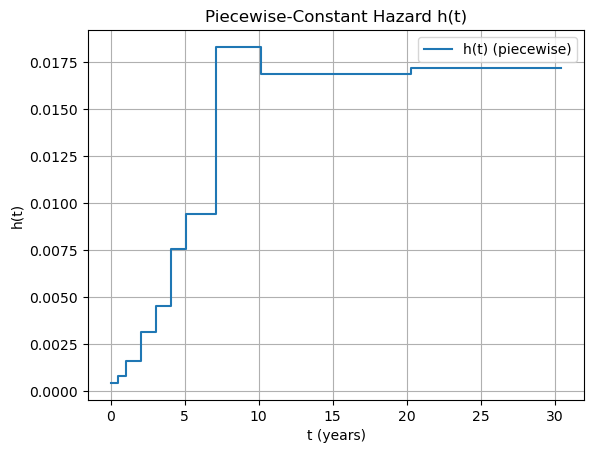

In [31]:
def piecewise_Q(t, T_knots, h):
    t_arr = np.atleast_1d(t).astype(float)
    out = np.empty_like(t_arr)
    T0 = 0.0

    for idx, tt in enumerate(t_arr):
        acc = 0.0
        prev = T0
        k = None
        for j, Tk in enumerate(T_knots):
            if tt <= Tk + 1e-14:
                k = j
                break
            acc += (Tk - prev) * h[j]
            prev = Tk
        if k is None:
            # beyond last knot -> extend with last hazard
            acc += (T_knots[-1] - prev) * h[-1]
            acc += (tt - T_knots[-1]) * h[-1]
        else:
            acc += (tt - prev) * h[k]
        out[idx] = np.exp(-acc)

    # ---- return scalar if input was scalar ----
    if out.size == 1:
        return float(out[0])
    return out
    
# Build a fine grid to 30y
t_fine = np.linspace(0, 30, 301)

# Survival using final h across knots
Q_fine = piecewise_Q(t_fine, T_knots, h)

# Plot Q
plt.figure()
plt.plot(t_fine, Q_fine, label="Q(0,t)")
plt.title("Survival Probability Curve")
plt.xlabel("t (years)"); plt.ylabel("Q(0,t)")
plt.grid(True); plt.legend(); plt.show()

# Plot piecewise-constant hazard as steps
plt.figure()
# represent hazard as step function
xs = [0.0] + T_knots
ys = [h[0]] + [val for val in h]  # step-wise
# Build step plot by repeating points
step_x = []
step_y = []
for k in range(len(T_knots)):
    left = 0.0 if k == 0 else T_knots[k-1]
    right = T_knots[k]
    step_x += [left, right]
    step_y += [h[k], h[k]]
plt.plot(step_x, step_y, drawstyle='default', label="h(t) (piecewise)")
plt.title("Piecewise-Constant Hazard h(t)")
plt.xlabel("t (years)"); plt.ylabel("h(t)")
plt.grid(True); plt.legend(); plt.show()


## 8) Non-standard CDS valuation (MTM)
We now value a **non-standard** quarterly CDS with premium dates on **Feb 15, May 15, Aug 15, Nov 15** and inputs from the assignment (face value, recovery, contractual spread, effective/present dates). We use the already-calibrated survival curve.


In [33]:
# === Build non-standard schedule (fixed to include dates before pres_date) ===
months_days_ns = [(2, 15), (5, 15), (8, 15), (11, 15)]

# Inputs
pres_date   = datetime.strptime("17-12-2014", "%d-%m-%Y")
eff_ns      = datetime.strptime("15-05-2012", "%d-%m-%Y")
maturity_ns = datetime.strptime("15-05-2037", "%d-%m-%Y")

# Generate a wide range that definitely covers eff..maturity (and pres)
start_year_ns = min(eff_ns.year, pres_date.year)     # 2012
end_year_ns   = maturity_ns.year                     # 2037

ns_dates_raw = []
for y in range(start_year_ns, end_year_ns + 1):
    for m, d in months_days_ns:
        ns_dates_raw.append(datetime(y, m, d))

# Roll weekends and keep only within [eff_ns, maturity_ns]
ns_dates = [roll_weekend_to_monday(d) for d in ns_dates_raw]
ns_dates = [d for d in ns_dates if eff_ns <= d <= maturity_ns]
ns_dates.sort()

# Premium times from eff_date (assignment uses Actual/360)
# (Keep using eff_date from your standard-schedule part so legs share the same origin.)
ns_times = [(d - eff_date).days / 360.0 for d in ns_dates if d >= eff_date]

# ---- Contract params ----
FV = 100.0     # $100mm in millions
R_ns = 0.55
spread_ns = 0.008  # 80 bp as decimal

# ---- Protection & premium legs (monthly grid for protection) ----
T_ns = (maturity_ns - eff_date).days / 360.0
K_ns = math.ceil(12 * T_ns)

prot_ns = protection_leg_approx(T_ns, K_ns, piecewise_Q, Z_func, T_knots, h)
rpv_ns  = rpv01_approx(ns_times, piecewise_Q, Z_func, T_knots, h)

protection_leg_val = (1 - R_ns) * prot_ns * FV
premium_leg_val    = spread_ns * rpv_ns * FV
full_mtm = protection_leg_val - premium_leg_val

# ---- Accrued premium at pres_date ----
# Find the latest premium date <= pres_date; if none, fall back to eff_ns
candidates = [d for d in ns_dates if d <= pres_date]
last_prem_before_pres = max(candidates) if candidates else eff_ns

accrued_days = (pres_date - last_prem_before_pres).days / 360.0
accrued_interest = -accrued_days * spread_ns * FV

clean_mtm = full_mtm - accrued_interest

print(f"Protection leg = {protection_leg_val:.6f} M")
print(f"Premium leg    = {premium_leg_val:.6f} M")
print(f"Full MTM       = {full_mtm:.6f} M")
print(f"Accrued Int.   = {accrued_interest:.6f} M")
print(f"Clean MTM      = {clean_mtm:.6f} M")


Protection leg = 8.163197 M
Premium leg    = 12.157628 M
Full MTM       = -3.994431 M
Accrued Int.   = -0.066667 M
Clean MTM      = -3.927764 M


## Non-Standard CDS Valuation Results (as of 17 Dec 2014)

- **Protection leg:** \$8.163 million  
  - Present value of the expected protection payoff (loss given default × survival curve × discounting).  

- **Premium leg:** \$12.158 million  
  - Present value of all contractual premium payments at the quoted spread (80 bp).  

- **Full MTM:** –\$3.994 million  
  - Net value = Protection leg – Premium leg.  
  - Negative means the CDS buyer would be paying more in premiums than the expected protection benefit under current market calibration.  

- **Accrued interest:** –\$0.067 million  
  - Premiums accumulate linearly between coupon dates. This is the accrued premium due as of the valuation date (from last payment date to 17 Dec 2014).  

- **Clean MTM:** –\$3.928 million  
  - Full mark-to-market adjusted for accrued interest.  
  - Reflects the fair settlement amount if the CDS position were transferred on the valuation date.  

### Interpretation
The negative clean MTM indicates that the **non-standard CDS is overpriced relative to the calibrated market survival curve and spreads**. In other words, the contractual spread of 80 bp is higher than the implied fair spread from the market data (standard CDS quotes), so the buyer of protection is paying more than the fair value for this contract.


## 9) Notes
- We used a **bracketed** root-finder for numerical robustness. You can switch to Newton–Raphson if you derive closed-form derivatives of the objective w.r.t. $ h_i $.  
- Day-count is **Actual/360** throughout, consistent with the brief.  
- The survival curve is calibrated **sequentially** to match each tenor’s spread.  
- Discount factors come from the **Nelson–Siegel** curve estimated via the given parameters.  
- Plots replicate what the original script produced, with clearer structure and comments.

---
**Tip:** If you want tables for `r̂(t)`, `Z(0,t)`, `h_k`, and `Q(0,t)`, we can add export cells to CSV/Excel upon request.
